# Level 1 Requirement Flowdown Overview

## L1-2 Localized Sources

> Carbon-I shall detect point sources exceeding 85 kg/hr for
CH₄, 50 metric tons/hr for CO₂, and 0.85 metric tons/hr for CO within high-priority 100 km×100 km regions for the Nominal
Scenario, with a revisit capability of ≤7 days. 

---

Set up the programming environment

In [1]:
# This script sets up the environment for the Carbon-I project, loading necessary packages and configurations.
using Pkg
Pkg.activate("../.."); # Actives the environment at the root of the project
# Using our Carbon-I and vSmartMOM packages (developed by our team)
using CarbonI, vSmartMOM, Printf
using CairoMakie, DelimitedFiles, Statistics, Interpolations, NCDatasets, InstrumentOperator, LinearAlgebra, Unitful, UnitfulEquivalences, LaTeXStrings

# Include some specific tools and configurations:
include(joinpath("../../src/Plots", "CI_colorsNew.jl"));
include(joinpath(dirname(pathof(CarbonI)), "readSun.jl"))
include(joinpath(dirname(pathof(CarbonI)), "Requirements", "common.jl"))
# Set plotting theme 
set_theme!(theme_ggplot2())

  Activating project at `~/code/gitHub/CarbonI`
┌ Info: CUDA-enabled GPU(s) detected
└ @ vSmartMOM /home/cfranken/code/gitHub/vSmartMOM.jl/src/vSmartMOM.jl:57
┌ Info: CUDA.CuDevice(0): NVIDIA A100-PCIE-40GB
└ @ vSmartMOM /home/cfranken/code/gitHub/vSmartMOM.jl/src/vSmartMOM.jl:59
┌ Info: CUDA.CuDevice(1): NVIDIA A100-PCIE-40GB
└ @ vSmartMOM /home/cfranken/code/gitHub/vSmartMOM.jl/src/vSmartMOM.jl:59


---

### Define Requirements with corresponding units:

Note that the fooprint size analysis as a function of pitch and roll angles is performed in src/notebooks/TargetFootprints.ipynb. This is the basis for defining a conservative Maximum Expected Value for the GSD, which propagates into a conservative requirement, which will be much easier to achieve in the center of the target mode, where the pitch angle is close to zero degrees.

Also note, we only adapt the cross-track GSD here, as the along-track GSD is given by the slit movement on the ground per exposure time, i.e. will remain the same, even though the ARF will change. The Jacob equation, however, relates to the GSD for which the single measurement precision is specified. 

In [2]:
# Define numbers from L1 Requirements

# Flux limits:
flux_detect_ch4_req = 85.0u"kg/hr"    # in kg CH4/hr
flux_detect_co2_req = 50e3u"kg/hr"    # in kg CO2/hr
flux_detect_co_req  = 0.85e3u"kg/hr"  # in kg CO/hr

# GSD, required and CBE for the target mode:
# Take larger pixels into account due to roll and pitch angles
offNadir_factor = 2 # Account for GSD increase (< pitch roll angle), determined in src/notebooks/TargetFootprints.ipynb
gsd_req = [(50.0*offNadir_factor)u"m", 50.0u"m"] # in m]
gsd_cbe = [(34.5*offNadir_factor)u"m", 30.3u"m"] # in m]

2-element Vector{Quantity{Float64, 𝐋, Unitful.FreeUnits{(m,), 𝐋, nothing}}}:
 69.0 m
 30.3 m

In [3]:
# Compute effective pixel sizes as the square root of the product of along and cross track GSDs:
req_pix = sqrt(prod(gsd_req));
cbe_pix = sqrt(prod(gsd_cbe));

## Theoretical basis for the requirement

> This is analogous to L1-1 but for Target viewing geometry, for which the single measurement precision is worse compared to global mode data ($ \sqrt{10} $ times due to the lack of co-adding) but the GSD is smaller, overcompsenating the loss in precision for point source detection.

Starting from the Jacob relation, the minimum detectable emission rate is

$$
Q_{\min} =
\underbrace{
\frac{M_{\mathrm{gas}}}{M_{\mathrm{dry}}}
\,\frac{\sigma_s\,p}{g}
}_{\displaystyle \sigma^*_{\mathrm{gas}}\;(\text{amount/area})}
\; q \, U \, W,
\tag{D-6}
$$

where  
- $ \sigma_s $ is the single-pixel column precision,  
- $ M_{\mathrm{gas}} $ and $ M_{\mathrm{dry}} $ are the molar masses of the target gas and dry air, respectively,  
- $ p $ is surface pressure, $ g $ is gravitational acceleration,  
- $ q $ is the detection scalar (we take $ q = 2 $),  
- $ U $ is the wind speed, and  
- $ W $ is the ground sampling distance (GSD).

---

### Flowdown to a requirement on $ \sigma_s $ (or $ \sigma_s \times W $)

Rearranging (D–6) gives a requirement on the product $ \sigma_s W $ for fixed $ U $ and $ q $:

$$
\sigma_{s}^{\mathrm{req}} \, W^{\mathrm{req}}
\;\le\;
Q^{\mathrm{req}}_{\min}
\;\frac{1}{M_{\mathrm{gas}}}
\;\underbrace{\frac{M_{\mathrm{dry}}\,g}{p}}_{\displaystyle 2.82 \times 10^{-6}\ \text{m}^2\!/\text{mol}}
\;\frac{1}{q\,U}.
$$

Once $ W^{\mathrm{req}} $ is chosen, the corresponding $ \sigma_s^{\mathrm{req}} $ follows directly from this inequality. The numerical factor $ 2.82 \times 10^{-6}\ \text{m}^2/\text{mol} $ reflects $ M_{\mathrm{dry}} g / p $ at standard conditions and should be recomputed if a different $ p $ is assumed.

In [4]:
# Define constants:
m = CarbonI.molar_mass()
C = CarbonI.Constants()
preFac = C.g * m.air / C.p # See equation above

# q=2 for detection limits
q = 2.0
# Wind speed for the reference scenario
wind_speed = 2.0u"m/s"
# Value of the prefactor (a constant for a given surface pressure)
@show C.g * m.air / C.p

(C.g * m.air) / C.p = 2.841957e-6 m^2 mol^-1


2.841957e-6 m^2 mol^-1

### Derive single measurement precision requirements

In [5]:
σ_ch4_req = flux_detect_ch4_req * preFac / req_pix / m.ch4 / wind_speed / q
σ_co2_req = flux_detect_co2_req * preFac / req_pix / m.co2 / wind_speed / q
σ_co_req  = flux_detect_co_req  * preFac / req_pix / m.co  / wind_speed / q

# Show computation as Markdown:
show_required_precisions(σ_ch4_req, σ_co2_req, σ_co_req; render=:markdown)

| **Gas** | **Required single-measurement precision** | **Unit** |
|:--------|:------------------------------------------|:---------|
| CH₄     | 14.8                                      | ppb      |
| CO₂     | 3.17                                      | ppm      |
| CO      | 84.7                                      | ppb      |


### Load Scenario and CBE + Required instrument specs

In [6]:
# Use the reference scenario
scenario = CarbonI.reference_scenario();

# Load CBE specs
cbe_specs = CarbonI.build_instrument("CBE");

# Load Required specs
req_specs = CarbonI.build_instrument("Requirement");

(ds["T"])[iLon, iLat, :, timeIndex] = Union{Missing, Float32}[187.60953, 195.1012, 201.35501, 208.64655, 216.49673, 222.47076, 227.39767, 230.89746, 235.26309, 242.40393, 250.36801, 259.4926, 268.20334, 272.86224, 273.1006, 270.50668, 266.17313, 261.9602, 257.33777, 253.24066, 249.31465, 244.15125, 240.6859, 238.05463, 235.39015, 231.98767, 228.57484, 226.37009, 223.45546, 222.34386, 220.49219, 217.9867, 216.47473, 214.98712, 213.25296, 210.32483, 207.75937, 206.41586, 207.52103, 209.51251, 210.57042, 216.20634, 224.16565, 232.26859, 240.40128, 247.10199, 252.58617, 255.18288, 257.9303, 263.41864, 267.52917, 272.1396, 276.66675, 280.92175, 284.42505, 286.95496, 289.00113, 290.2957, 290.15128, 289.2277, 289.0184, 290.03265, 291.2717, 292.5702, 293.89865, 295.23, 296.56677, 297.8983, 299.22983, 300.5767, 301.94052, 303.46246]


In [7]:
# Create required Instrument model 
ins_req = InstrumentOperator.createGratingNoiseModel(req_specs.ET, req_specs.Pitch, 
		req_specs.FPA_quantum_efficiency, req_specs.bench_efficiency, 
		req_specs.Fnumber, 2*req_specs.SSI, 
		(req_specs.readout_noise), req_specs.dark_current); 

# Create required Instrument model
ins_cbe = InstrumentOperator.createGratingNoiseModel(cbe_specs.ET, cbe_specs.Pitch, 
		cbe_specs.FPA_quantum_efficiency, cbe_specs.bench_efficiency, 
		cbe_specs.Fnumber, 2*cbe_specs.SSI, 
		(cbe_specs.readout_noise), cbe_specs.dark_current); 

# Set up data for Required and CBE cases, all instrument parameters are changed per CBE and Required specifications:
soil_req, x_req, solarIrr_req, σ_matrix_req, profile_req, h_req, Sₐ_req = setup_data(scenario, req_specs)
soil_cbe, x_cbe, solarIrr_cbe, σ_matrix_cbe, profile_cbe, h_cbe, Sₐ_cbe = setup_data(scenario, cbe_specs);

In [8]:
# Obtain wavelength grid and spectrally resolved albedo from the scenarios (albedo identical per case)
ll = length(req_specs.modelling_wl);
refl_req   = scenario.surface_albedo(req_specs.modelling_wl);
refl_cbe   = scenario.surface_albedo(req_specs.modelling_wl);

---

### Compute single measurement precisions for Required and CBE specifications

In [9]:
# This is calling a helper function to calculate precision errors and the Forward model run F(x) for the Required and CBE cases:
# The function calc_rel_error is defined in the common.jl file.
error_req, F_req = calc_rel_error(req_specs, x_req, solarIrr_req, refl_req, scenario.sza, σ_matrix_req, profile_req, h_req, ins_req, Sₐ_req, return_F=true) 
error_cbe, F_cbe = calc_rel_error(cbe_specs, x_cbe, solarIrr_cbe, refl_cbe, scenario.sza, σ_matrix_cbe, profile_cbe, h_cbe, ins_cbe, Sₐ_cbe, return_F=true) 

(Dict{Any, Any}("ch4" => 10.169267298478452, "h2o" => 25789.69301820579, "co" => 42.66610353980517, "n2o" => 19.75235224462953, "hdo" => 174588.2237841886, "c2h6" => 25.612590001902237, "co2" => 2197.705247128854, "co213" => 15617.578884458344), [2.9347659998209354, 2.9244170677547787, 2.7861478511231725, 2.458574551410483, 2.3708779581014725, 2.101959738259233, 1.5845150034998492, 1.8872018549331286, 2.487426918603361, 2.544563990075057  …  1.5793954880093588, 1.356428405620226, 0.9376469195457674, 0.8197518012739107, 0.7713671562665957, 0.7435625617427714, 0.689547995241922, 0.32934537134544783, 0.2291102579894721, 0.540061696871597])

In [10]:
# write out resulting errors after co-adding (tool in common.jl)
sqrtN = 1.0 # No co-adding in Target mode
md_expected_precisions(error_cbe, sqrtN; sigdigits=4)

| Gas | Expected single-measurement precision | Unit |
|-----|--------------------------------------:|------|
| CH₄ | 10.17 | ppb |
| CO₂ | 2.198 | ppm |
| CO | 42.67 | ppb |


---

### Probe phase space of instrument performance
Here, we iterate over readout noise and total system efficiency to derive the dependency of precision on instrument specs

In [11]:
# Now vary total efficiency at two different readout noise levels:

TotalEfficiencies = 0.2:0.05:1.0
gas_errors_100 = zeros(3,length(TotalEfficiencies))
gas_errors_120 = zeros(3,length(TotalEfficiencies))
for (i,efficiency) in enumerate(TotalEfficiencies)
    # Create instrument Specs here:
    # (here we need to use 57ms integration time for req. as we count larger pixels along track dimension than in CBE)
    ins_req_100 = InstrumentOperator.createGratingNoiseModel(57.0u"ms", req_specs.Pitch, 1.0, efficiency, req_specs.Fnumber, 2*req_specs.SSI, (100.0), req_specs.dark_current); 
    ins_req_120 = InstrumentOperator.createGratingNoiseModel(57.0u"ms", req_specs.Pitch, 1.0, efficiency, req_specs.Fnumber, 2*req_specs.SSI, (120.0), req_specs.dark_current); 
    # Create an error for 100 and 120e- for the respective efficiency
    error_varied_100 = calc_rel_error(req_specs, x_req, solarIrr_req, refl_req, scenario.sza, σ_matrix_req, profile_req, h_req, ins_req_100, Sₐ_req) 
    error_varied_120 = calc_rel_error(req_specs, x_req, solarIrr_req, refl_req, scenario.sza, σ_matrix_req, profile_req, h_req, ins_req_120, Sₐ_req) 
    # Store Data
    gas_errors_100[1,i] = error_varied_100["ch4"]
    gas_errors_120[1,i] = error_varied_120["ch4"] 
    gas_errors_100[2,i] = error_varied_100["co2"]
    gas_errors_120[2,i] = error_varied_120["co2"] 
    gas_errors_100[3,i] = error_varied_100["co"]
    gas_errors_120[3,i] = error_varied_120["co"] 
end

In [12]:
# Create Unit free values for interpolation
ch4_req_ppb = ustrip(uconvert(u"ppb", σ_ch4_req))
co2_req_ppb = ustrip(uconvert(u"ppb", σ_co2_req))
co_req_ppb  = ustrip(uconvert(u"ppb", σ_co_req))

# Create an interpolation function to get the required optical efficiency for a given readout noise and proxy error for N2O
# Annoying as it requires ascending order in the x-axis
efficiency_100_ch4 = LinearInterpolation(reverse(gas_errors_100[1,:]./ch4_req_ppb), reverse(TotalEfficiencies), extrapolation_bc=Line());
efficiency_120_ch4 = LinearInterpolation(reverse(gas_errors_120[1,:]./ch4_req_ppb), reverse(TotalEfficiencies), extrapolation_bc=Line());

efficiency_100_co2 = LinearInterpolation(reverse(gas_errors_100[2,:]./co2_req_ppb), reverse(TotalEfficiencies), extrapolation_bc=Line());
efficiency_120_co2 = LinearInterpolation(reverse(gas_errors_120[2,:]./co2_req_ppb), reverse(TotalEfficiencies), extrapolation_bc=Line());

efficiency_100_co = LinearInterpolation(reverse(gas_errors_100[3,:]./co_req_ppb), reverse(TotalEfficiencies), extrapolation_bc=Line());
efficiency_120_co = LinearInterpolation(reverse(gas_errors_120[3,:]./co_req_ppb), reverse(TotalEfficiencies), extrapolation_bc=Line());

### Find driving requirement
by finding the maximum of the required efficiency per gas

In [13]:
# Concatenate all model runs:
all_curves = [efficiency_100_ch4, efficiency_120_ch4, efficiency_100_co2, efficiency_120_co2, efficiency_100_co, efficiency_120_co];
# Find driving requirement across all gases:
driving_req = maximum([eff(1.0) for eff in all_curves])

0.40265691358260003

req_eff_120 = 0.40265691358260003


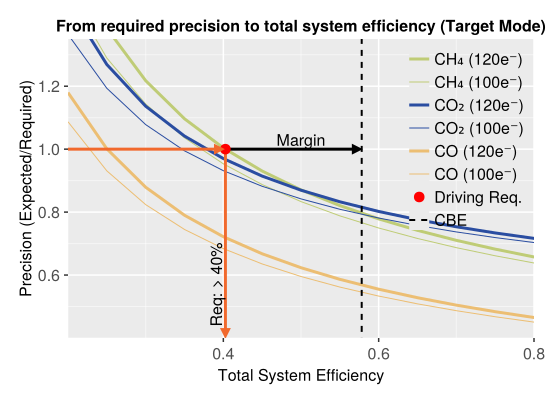

In [14]:
#all_curves = [efficiency_100_ch4, efficiency_120_ch4, efficiency_100_co2, efficiency_120_co2, efficiency_100_co, efficiency_120_co];
#driving-req = minimum([eff(1.0) for eff in all_curves])
req_eff_120     = driving_req;
req_error       = 1.0;
eff_cbe = cbe_specs.bench_efficiency * cbe_specs.FPA_quantum_efficiency

@show req_eff_120
f = Figure(resolution=(550,400))
ax = Axis(f[1,1], xlabel="Total System Efficiency", ylabel="Precision (Expected/Required)",  title="From required precision to total system efficiency (Target Mode)")
# For CH4 (100 and 120e-)
lines!(ax, TotalEfficiencies, gas_errors_120[1,:]./ch4_req_ppb, color=CarbonI_colors[7], linewidth=3, label="CH₄ (120e⁻)")
lines!(ax, TotalEfficiencies, gas_errors_100[1,:]./ch4_req_ppb, color=CarbonI_colors[7], linewidth=1, label="CH₄ (100e⁻)")
# For CO2 (100 and 120e-)
lines!(ax, TotalEfficiencies, gas_errors_120[2,:]./co2_req_ppb, color=CarbonI_colors[4], linewidth=3, label="CO₂ (120e⁻)")
lines!(ax, TotalEfficiencies, gas_errors_100[2,:]./co2_req_ppb, color=CarbonI_colors[4], linewidth=1, label="CO₂ (100e⁻)")
# For CO (100 and 120e-)
lines!(ax, TotalEfficiencies, gas_errors_120[3,:]./co_req_ppb, color=CarbonI_colors[6], linewidth=3, label="CO (120e⁻)")
lines!(ax, TotalEfficiencies, gas_errors_100[3,:]./co_req_ppb, color=CarbonI_colors[6], linewidth=1, label="CO (100e⁻)")

# Lines for Driving Requirement

arrows!(ax, [req_eff_120,],[req_error,],[0,],[-req_error+0.42,],arrowsize = 15, linewidth=3,color = CarbonI_colors[5])
text!(ax, "Req: > $(round(Int, 100req_eff_120))%", position = (req_eff_120, 0.57),
    align = (:center, :bottom), color = :black, rotation=π/2)

# Indicate Margins
arrows!(ax, [req_eff_120+0.002,],[req_error,],[eff_cbe-req_eff_120-0.01,],[0,],arrowsize = 15, linewidth=3, color = :black)
text!(ax, "Margin", position = (0.5, req_error),  align = (:center, :bottom), color = :black)
scatter!(ax, [req_eff_120], [req_error], color=:red, markersize=15, label="Driving Req.")
arrows!(ax, [0.0,],[1,],[req_eff_120-0.01,],[0,],arrowsize = 15, linewidth=3, color = CarbonI_colors[5])
# Show CBE Total Efficiency
lines!(ax, [eff_cbe,eff_cbe], [0,1.35], color=:black, linestyle=:dash, linewidth=2, label="CBE")

xlims!(ax,0.2,0.8)
ylims!(ax,0.4,1.35)
axislegend(ax,position = :rt)
save("../../plots/final/Level1-2-EfficiencyDerivation_perGas.pdf",f)
f

In [15]:
# Save lines to merge later with other requirements:
AllData = [TotalEfficiencies gas_errors_120[1,:]./ch4_req_ppb  gas_errors_100[1,:]./ch4_req_ppb gas_errors_120[2,:]./co2_req_ppb gas_errors_100[2,:]./co2_req_ppb  gas_errors_120[3,:]./co_req_ppb   gas_errors_100[3,:]./co_req_ppb]
writedlm("../../data/L1s/L1-2_lines.dat", AllData)

In [16]:
from_w_to_photons = 5.03e12 # Conversion factor from mW/m²/nm/sr to photons/m²/sr/nm at a specific wavelength (choice is irrelevant here)
refRadiance = 1.0e16 # in photons/s/m²/nm
ins_req_forSNR = InstrumentOperator.createGratingNoiseModel(44.0u"ms", req_specs.Pitch, 1.0, req_eff_120, req_specs.Fnumber, 2*req_specs.SSI, (120.0), req_specs.dark_current);
ins_cbe_forSNR = InstrumentOperator.createGratingNoiseModel(44.0u"ms", cbe_specs.Pitch, 1.0, eff_cbe, cbe_specs.Fnumber, 2*cbe_specs.SSI, (100.0), cbe_specs.dark_current);
# Use reference Wavelength here (just for conversion)
ref_wl = 2250;


refRadiance_mw = refRadiance / from_w_to_photons / ref_wl
nesr_req_forSNR = InstrumentOperator.noise_equivalent_radiance(ins_req_forSNR, (ref_wl)u"nm", (refRadiance_mw)u"mW/m^2/nm/sr");
nesr_cbe_forSNR = InstrumentOperator.noise_equivalent_radiance(ins_cbe_forSNR, (ref_wl)u"nm", (refRadiance_mw)u"mW/m^2/nm/sr");

@printf("Required SNR @1e16 photons/m2/sr/nm/s: %.4g\n",  refRadiance_mw/(nesr_req_forSNR[1]./1u"mW/m^2/nm/sr"))
@printf("CBE      SNR @1e16 photons/m2/sr/nm/s: %.4g ",  refRadiance_mw/(nesr_cbe_forSNR[1]./1u"mW/m^2/nm/sr"))

Required SNR @1e16 photons/m2/sr/nm/s: 78.46
CBE      SNR @1e16 photons/m2/sr/nm/s: 110.3 

---

### Compute performance of the CBE design

In [17]:
# Going back full circle from CBE to expected L1 values
# For CH4
ch4_error_ppb = error_cbe["ch4"]u"ppb"
flux_ch4_cbe_limit = uconvert(u"kg/hr", ch4_error_ppb * C.p /(C.g*m.air) * cbe_pix * m.ch4 * wind_speed * q )

# For CO2:
co2_error_ppb = error_cbe["co2"]u"ppb"
flux_co2_cbe_limit = uconvert(u"kg/hr", co2_error_ppb * C.p /(C.g*m.air) * cbe_pix * m.co2 * wind_speed * q )

# For CO:
co_error_ppb = error_cbe["co"]u"ppb"
flux_co_cbe_limit = uconvert(u"kg/hr", co_error_ppb * C.p /(C.g*m.air) * cbe_pix * m.co * wind_speed * q)

@printf("CBE Flux Detection for CH₄ : %.3g kg/hr \n", ustrip(flux_ch4_cbe_limit)) 
@printf("CBE Flux Detection for CO₂ : %.3g kg/hr \n", ustrip(flux_co2_cbe_limit))
@printf("CBE Flux Detection for CO  : %.3g kg/hr",    ustrip(flux_co_cbe_limit))

CBE Flux Detection for CH₄ : 37.8 kg/hr 
CBE Flux Detection for CO₂ : 2.24e+04 kg/hr 
CBE Flux Detection for CO  : 277 kg/hr

In [18]:
# Convert everything to the display units you want first
σ_ch4_req_ppb = ustrip(uconvert(u"ppb", σ_ch4_req))
σ_co2_req_ppm = ustrip(uconvert(u"ppm", σ_co2_req))
σ_co_req_ppb  = ustrip(uconvert(u"ppb", σ_co_req))

σ_ch4_exp_ppb = error_cbe["ch4"] / sqrtN
σ_co2_exp_ppm = error_cbe["co2"] / 1000 / sqrtN
σ_co_exp_ppb  = error_cbe["co"]  / sqrtN

rows = [
    (gas="CH₄", unit="ppb", req=σ_ch4_req_ppb, exp=σ_ch4_exp_ppb),
    (gas="CO₂", unit="ppm", req=σ_co2_req_ppm, exp=σ_co2_exp_ppm),
    (gas="CO",  unit="ppb", req=σ_co_req_ppb,  exp=σ_co_exp_ppb),
]

req_vs_exp_table(rows; sigdigits=3, render=:markdown)

| Gas | Required σ | Expected σ | Margin wrt to CBE | Margin wrt to REQ |  Unit |
|-----|-----------:|-----------:|-------:|-------:|------|
| CH₄ | 14.8 | 10.2 | -45.4% | +31.2% |ppb |
| CO₂ | 3.17 | 2.2 | -44.3% | +30.7% |ppm |
| CO | 84.7 | 42.7 | -98.5% | +49.6% |ppb |
